In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras, optimizers
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA


---

## Doc data

In [2]:
diabetes = pd.read_csv("diabetes2.csv")
hivs = pd.read_csv("HIV.csv")

In [3]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               1112 non-null   int64  
 1   Glucose                   1112 non-null   int64  
 2   BloodPressure             1112 non-null   int64  
 3   SkinThickness             1112 non-null   int64  
 4   Insulin                   1112 non-null   int64  
 5   BMI                       1112 non-null   float64
 6   DiabetesPedigreeFunction  1112 non-null   float64
 7   Age                       1112 non-null   int64  
 8   Outcome                   1112 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 78.3 KB


In [4]:
hivs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82254 entries, 0 to 82253
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   smiles      41127 non-null  object 
 1   activity    41127 non-null  object 
 2   HIV_active  41127 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.9+ MB


---

## 1. Bỏ dữ liệu chứa 0, trừ trường outcome

In [5]:
columns = diabetes.iloc[:, :-1].columns

In [6]:
diabetes[columns] = diabetes[columns].replace(0, pd.NA)
processed_diabetes = diabetes.dropna()
processed_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 484 entries, 3 to 1109
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               484 non-null    object 
 1   Glucose                   484 non-null    object 
 2   BloodPressure             484 non-null    object 
 3   SkinThickness             484 non-null    object 
 4   Insulin                   484 non-null    object 
 5   BMI                       484 non-null    object 
 6   DiabetesPedigreeFunction  484 non-null    float64
 7   Age                       484 non-null    int64  
 8   Outcome                   484 non-null    int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 37.8+ KB


In [7]:
processed_diabetes.to_csv("diabetes_cleaned.csv", index=False)

---

## 2. Dùng mạng NN để dự đoán kết quả outcome

- Phân loại biến

In [8]:
X = processed_diabetes.iloc[:, :-1]
y = processed_diabetes.iloc[:, -1]

- Scale dữ liệu theo pp chuẩn

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# X_scaled

- Chia train, test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=192)
print(X_train.shape)
print(X_test.shape)

(363, 8)
(121, 8)


- Sử dụng keras để tạo layers và train mô hình NN
- Gồm 2 tầng ẩn, số node lần lượt là 32 và 16, activation function sử dụng relu
- Tầng output dự đoán kết quả nhị phân nên sử dụng sigmoid

In [11]:
def gen_model(layers: list=[], input_shape: tuple=()):
    model = None
    if (len(layers) != 0):
        model = keras.models.Sequential(layers)
    else:
        model = keras.models.Sequential([
            keras.layers.Input(shape=input_shape),
            keras.layers.Dense(32, activation="relu"),
            keras.layers.Dense(16, activation="relu"),
            keras.layers.Dense(1, activation="sigmoid")
        ])

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

model = gen_model(input_shape=(X_train.shape[1],))
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

- Dự đoán kết quả

In [12]:
y_pred = model.predict(X_test).T[0]
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
cm


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


array([[79,  4],
       [10, 28]], dtype=int64)

---

## 3. Sắp xếp trọng số và vẽ đồ thị 

### a. Sắp xếp trọng số theo cột

In [13]:
weights = model.get_weights()[0]
weights_sum = np.sum(np.abs(weights), axis=1)
weights_sum

array([7.774313 , 7.4870214, 7.100338 , 8.405589 , 7.956604 , 7.611677 ,
       8.698769 , 9.541032 ], dtype=float32)

In [14]:
weights_df = pd.DataFrame({"Column" : columns, "Weight" : weights_sum})
weights_df = weights_df.sort_values(by="Weight", ascending=False)
weights_df

,Column,Weight
7,Age,9.541032
6,DiabetesPedigreeFunction,8.698769
3,SkinThickness,8.405589
4,Insulin,7.956604
0,Pregnancies,7.774313
5,BMI,7.611677
1,Glucose,7.487021
2,BloodPressure,7.100338


### b. Vẽ đồ thị so sánh accuracy và loss

In [15]:
acc = history.history["accuracy"]
losses = history.history["loss"]
epochs = history.epoch

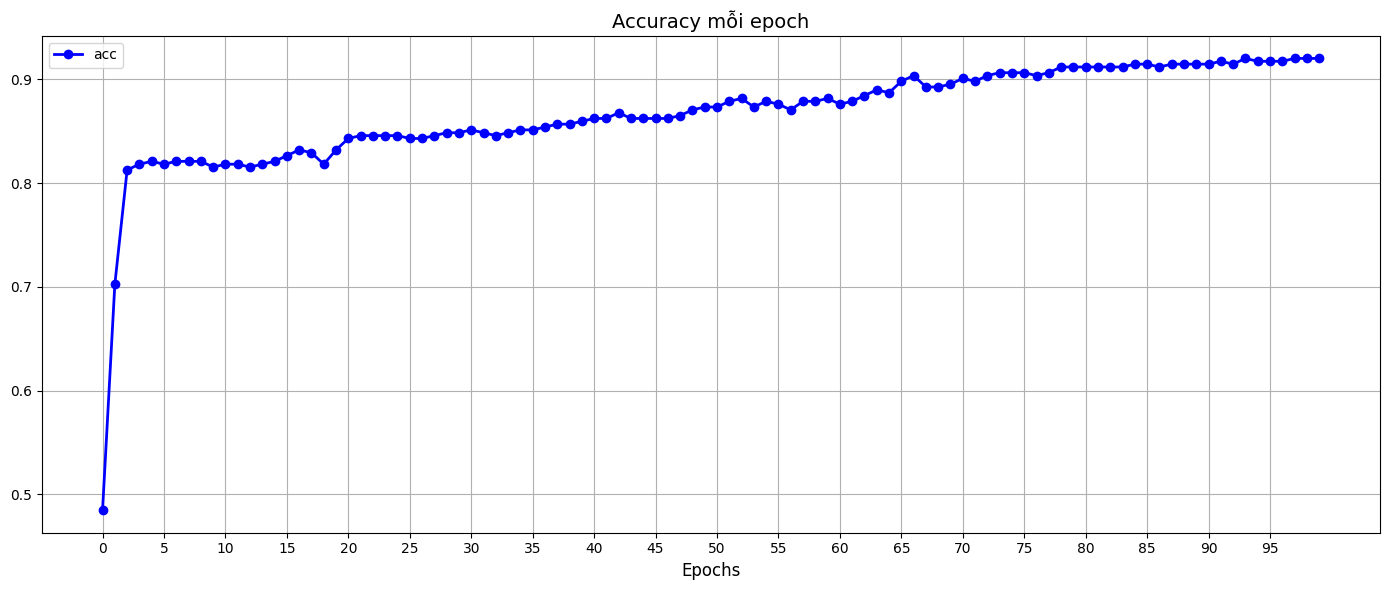

In [16]:
plt.figure(figsize=(14, 6))

plt.plot(epochs, acc, color="blue", marker='o', linestyle='-', linewidth=2, markersize=6)

plt.title('Accuracy mỗi epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)

plt.grid(True)
plt.legend(["acc"], loc='best')
plt.xticks(np.arange(min(epochs), max(epochs) + 1, 5))

plt.tight_layout()
plt.show()

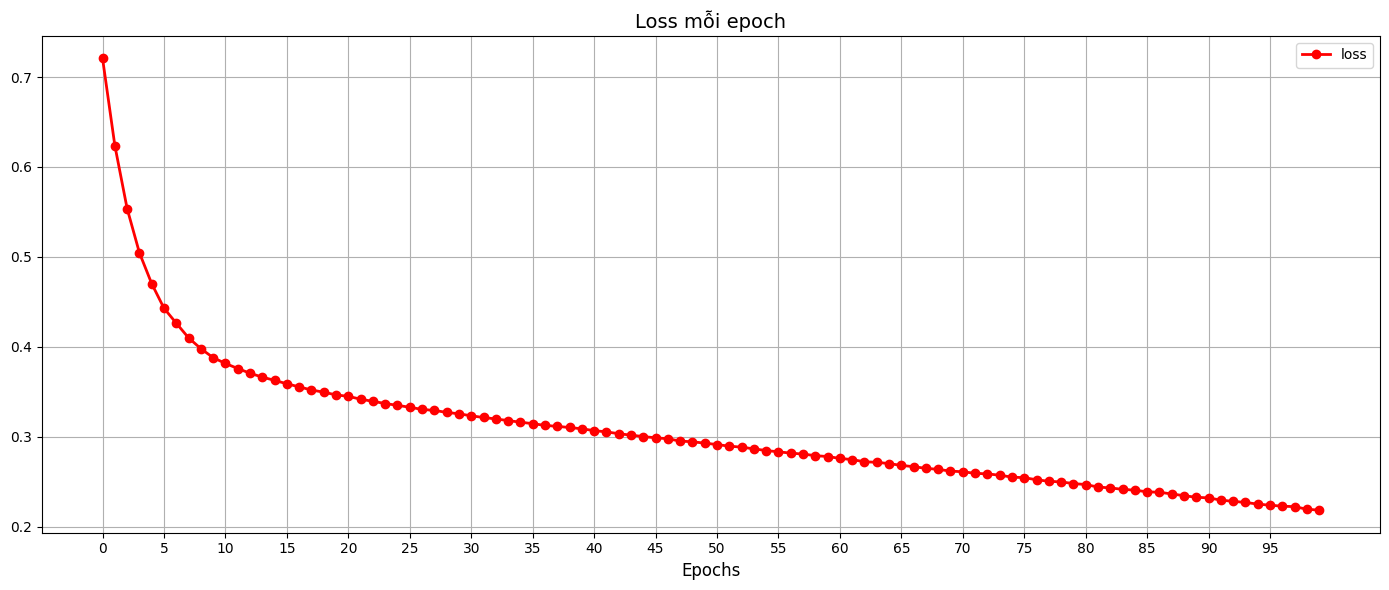

In [17]:
plt.figure(figsize=(14, 6))

plt.plot(epochs, losses, color="red", marker='o', linestyle='-', linewidth=2, markersize=6)

plt.title('Loss mỗi epoch', fontsize=14)
plt.xlabel('Epochs', fontsize=12)

plt.grid(True)
plt.legend(["loss"], loc='best')
plt.xticks(np.arange(min(epochs), max(epochs) + 1, 5))

plt.tight_layout()
plt.show()

---

## 4. Dự đoán kết quả

In [18]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:.2f}%")

Accuracy: 88.43%


=> Mô hình NN có accuracy là 83.5%

---

## 5. So sánh kết quả mô hình PLS + PCA với mô hình NN

### a. PLS + PCA

In [19]:
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

In [20]:
pls = PLSRegression(n_components=3)
pls.fit(X_train_pca, y_train)

y_pred = pls.predict(X_test_pca)
y_pred = (y_pred > 0.5).astype(int)
# y_pred

In [21]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[72, 11],
       [21, 17]], dtype=int64)

In [22]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:.2f}%")

Accuracy: 73.55%


=> Mô hình PLS kết hợp với giảm chiều PCA có accuracy là 73.5%